In [ ]:
#Importing the Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
import sklearn
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM, Dropout, advanced_activations
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates

In [ ]:
from sklearn import linear_model
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import adam_v2
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

# Get the Dataset

In [ ]:
df=pd.read_csv("HDFCBANK.csv",na_values=None,index_col='Date',parse_dates=True,infer_datetime_format=True)
df=df.drop(['Trades','Deliverable Volume','%Deliverble'],axis=1)
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover
Date,,,,,,,,,,,
2000-01-03,HDFCBANK,EQ,157.40,166.00,170.00,166.00,170.00,170.00,169.52,33259,5.638122e+11
2000-01-04,HDFCBANK,EQ,170.00,182.00,183.45,171.00,174.00,173.80,174.99,168710,2.952261e+12
2000-01-05,HDFCBANK,EQ,173.80,170.00,173.90,165.00,168.00,166.95,169.20,159820,2.704094e+12
2000-01-06,HDFCBANK,EQ,166.95,168.00,170.00,165.30,168.95,168.30,168.44,85026,1.432166e+12
2000-01-07,HDFCBANK,EQ,168.30,162.15,171.00,162.15,170.75,168.35,166.79,85144,1.420158e+12


In [ ]:
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()
df['SMA_100'] = df['Close'].rolling(100, min_periods=1).mean()

**Print the shape of Dataframe  and Check for Null Values**

In [ ]:
print("Dataframe Shape: ",df.shape)
print("Null Value Present: ",df.isnull().values.any())
df.info()

Dataframe Shape:  (5306, 13)
Null Value Present:  False
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5306 entries, 2000-01-03 to 2021-04-30
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Symbol      5306 non-null   object 
 1   Series      5306 non-null   object 
 2   Prev Close  5306 non-null   float64
 3   Open        5306 non-null   float64
 4   High        5306 non-null   float64
 5   Low         5306 non-null   float64
 6   Last        5306 non-null   float64
 7   Close       5306 non-null   float64
 8   VWAP        5306 non-null   float64
 9   Volume      5306 non-null   int64  
 10  Turnover    5306 non-null   float64
 11  EMA_200     5306 non-null   float64
 12  SMA_100     5306 non-null   float64
dtypes: float64(10), int64(1), object(2)
memory usage: 580.3+ KB


In [ ]:
df['Volume_lag_1d'] = df['Volume'].shift(1)

**Set Target Variable and Select the Features**

In [ ]:
features = ['Prev Close','Open','High','Low','Last','VWAP','Volume_lag_1d','SMA_100','EMA_200']
#df['SMA_100'] = df['Close'].rolling(100, min_periods=100).mean()
df.dropna(inplace=True)
output_var = pd.DataFrame(df['Close'])
df[features].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5305 entries, 2000-01-04 to 2021-04-30
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Prev Close     5305 non-null   float64
 1   Open           5305 non-null   float64
 2   High           5305 non-null   float64
 3   Low            5305 non-null   float64
 4   Last           5305 non-null   float64
 5   VWAP           5305 non-null   float64
 6   Volume_lag_1d  5305 non-null   float64
 7   SMA_100        5305 non-null   float64
 8   EMA_200        5305 non-null   float64
dtypes: float64(9)
memory usage: 414.5 KB


**Print the shape of Dataframe-Features  and Check for Null Values-Features**

In [ ]:
print("Dataframe Shape: ",df[features].shape)
print("Null Value Present: ",df[features].isnull().values.any())

Dataframe Shape:  (5305, 9)
Null Value Present:  False


In [ ]:
df[features].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5305 entries, 2000-01-04 to 2021-04-30
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Prev Close     5305 non-null   float64
 1   Open           5305 non-null   float64
 2   High           5305 non-null   float64
 3   Low            5305 non-null   float64
 4   Last           5305 non-null   float64
 5   VWAP           5305 non-null   float64
 6   Volume_lag_1d  5305 non-null   float64
 7   SMA_100        5305 non-null   float64
 8   EMA_200        5305 non-null   float64
dtypes: float64(9)
memory usage: 414.5 KB


**Plot the Close Value**

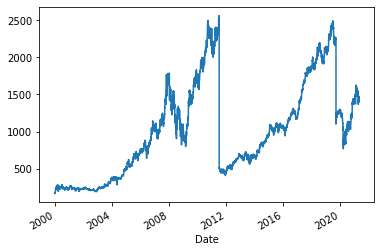

In [ ]:
df['Close'].plot()

# Scaling using MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Prev Close,Open,High,Low,Last,VWAP,Volume_lag_1d,SMA_100,EMA_200
Date,,,,,,,,,
2000-01-04,0.002747,0.008258,0.006438,0.005841,0.004583,0.005641,0.000320,0.002127,0.000145
2000-01-05,0.004329,0.003266,0.002484,0.003338,0.002083,0.003237,0.001667,0.001369,0.000131
2000-01-06,0.001478,0.002434,0.000869,0.003463,0.002479,0.002922,0.001579,0.001145,0.000122
2000-01-07,0.002040,0.000000,0.001283,0.002149,0.003229,0.002237,0.000835,0.001015,0.000115
2000-01-10,0.002060,0.004472,0.004803,0.003338,0.001375,0.002652,0.000836,0.000741,0.000095


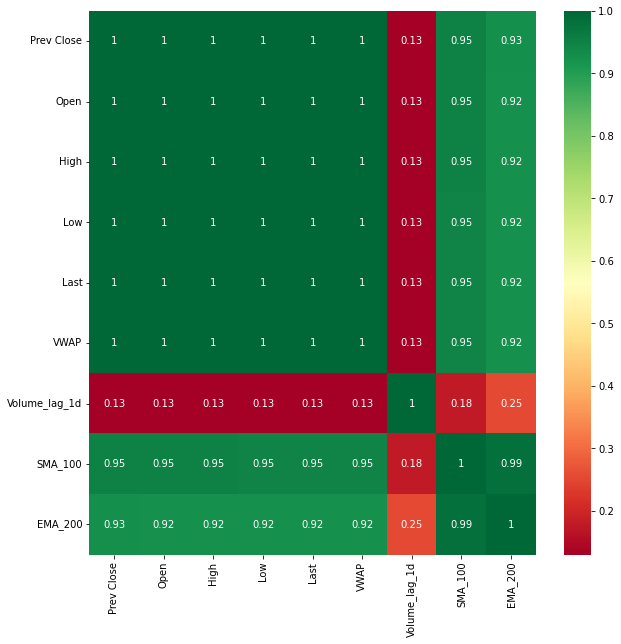

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.subplots(figsize=(10,10))
sns.heatmap(feature_transform.corr(),cmap='RdYlGn',annot=True)
plt.show()

#FIT PCA MODEL

**FIT PCA MODEL,THE NUMBER OF COMPONENTS WILL BE SAME AS NUMBER OF VARIABLES**

In [ ]:
from sklearn.decomposition import PCA
pca=PCA().fit(feature_transform[features])
pca

PCA()

In [ ]:
str(pca.explained_variance_ratio_.sum())

'1.0'

In [ ]:
str(pca.explained_variance_ratio_)

'[9.71440288e-01 2.41397024e-02 2.84502930e-03 1.13876945e-03\n 2.93982442e-04 6.86473449e-05 5.82551181e-05 1.07632818e-05\n 4.56257463e-06]'

**FIT PCA MODEL,THE NUMBER OF COMPONENTS WILL BE 5 FOR WHICH THE EXPLAINED VARIANCE RATIO.SUM WILL BE 99.99%**

In [ ]:
pca=PCA(5).fit(feature_transform)

In [ ]:

str(pca.explained_variance_ratio_.sum())

'0.99985777168059'

In [ ]:
str(pca.explained_variance_ratio_)

'[9.71440288e-01 2.41397024e-02 2.84502930e-03 1.13876945e-03\n 2.93982442e-04]'

In [ ]:
pca.explained_variance_

array([5.66800253e-01, 1.40846428e-02, 1.65997164e-03, 6.64430764e-04,
       1.71528116e-04])

In [ ]:

pca_df=pd.DataFrame(pca.components_,columns=df[features].columns)
pca_df

,Prev Close,Open,High,Low,Last,VWAP,Volume_lag_1d,SMA_100,EMA_200
0,0.349751,0.349484,0.351080,0.347188,0.350157,0.348709,0.008219,0.369545,0.361802
1,-0.196618,-0.209370,-0.210368,-0.211037,-0.211793,-0.210834,0.101215,0.506590,0.687407
2,0.011139,0.034259,0.039436,0.028596,0.036613,0.034412,0.847052,-0.453500,0.265793
3,0.000272,-0.017688,-0.009065,-0.027667,-0.016712,-0.019656,0.521477,0.632747,-0.570847
4,0.907977,-0.070522,-0.189597,-0.175027,-0.249355,-0.202516,0.008314,-0.026917,0.006143


In [ ]:

feature_transform.shape

(5305, 9)

In [ ]:
#transformed features,instead of having 8,we have 5 now.this can now be plugged into any further modelling work
x_scaled_transf=pca.fit_transform(feature_transform)

In [ ]:
x_scaled_transf=pd.DataFrame(x_scaled_transf,columns=('P1','P2','P3','P4','P5'))
x_scaled_transf.shape

(5305, 5)

In [ ]:

x_scaled_transf.head()

,P1,P2,P3,P4,P5
0,-1.005883,-0.029695,-0.013250,0.003790,-0.002278
1,-1.011319,-0.026822,-0.012324,0.004304,0.001840
2,-1.013188,-0.025919,-0.012416,0.004146,-0.000436
3,-1.014186,-0.025491,-0.013084,0.003757,0.000346
4,-1.011581,-0.027269,-0.012691,0.003474,-0.000440


In [ ]:
correlation=x_scaled_transf.corr()
correlation

,P1,P2,P3,P4,P5
P1,1.000000e+00,3.877810e-16,3.322453e-16,-6.073956e-17,1.492645e-17
P2,3.877810e-16,1.000000e+00,3.338371e-16,-1.802680e-16,1.091552e-16
P3,3.322453e-16,3.338371e-16,1.000000e+00,-1.160053e-16,-3.269199e-16
P4,-6.073956e-17,-1.802680e-16,-1.160053e-16,1.000000e+00,-3.484048e-16
P5,1.492645e-17,1.091552e-16,-3.269199e-16,-3.484048e-16,1.000000e+00


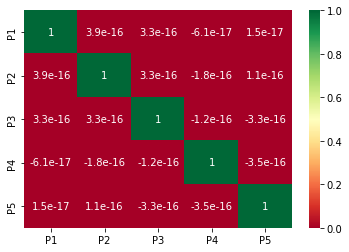

In [ ]:
sns.heatmap(correlation,cmap="RdYlGn",annot=True)
plt.show()

In [ ]:
feature_transform=x_scaled_transf
feature_transform['Date'] = df.index
feature_transform = feature_transform.set_index('Date')
feature_transform.head()

,P1,P2,P3,P4,P5
Date,,,,,
2000-01-04,-1.005883,-0.029695,-0.013250,0.003790,-0.002278
2000-01-05,-1.011319,-0.026822,-0.012324,0.004304,0.001840
2000-01-06,-1.013188,-0.025919,-0.012416,0.004146,-0.000436
2000-01-07,-1.014186,-0.025491,-0.013084,0.003757,0.000346
2000-01-10,-1.011581,-0.027269,-0.012691,0.003474,-0.000440


**Splitting to Training set and Test set**

In [ ]:
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
  X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
  y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

#LSTM MODEL with moving averages

**Process the data for LSTM**

In [ ]:
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

**Building the LSTM Model**

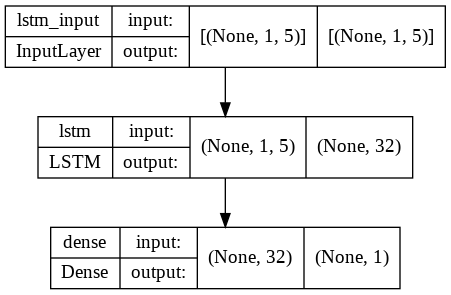

In [ ]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

**Model Training**

In [ ]:

history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
603/603 [==============================] - 3s 3ms/step - loss: 1334303.6250
Epoch 2/100
603/603 [==============================] - 2s 3ms/step - loss: 1284359.1250
Epoch 3/100
603/603 [==============================] - 2s 3ms/step - loss: 1187094.6250
Epoch 4/100
603/603 [==============================] - 2s 2ms/step - loss: 1065554.0000
Epoch 5/100
603/603 [==============================] - 2s 3ms/step - loss: 933140.5625
Epoch 6/100
603/603 [==============================] - 2s 3ms/step - loss: 798071.2500
Epoch 7/100
603/603 [==============================] - 2s 3ms/step - loss: 666271.0000
Epoch 8/100
603/603 [==============================] - 2s 3ms/step - loss: 542230.4375
Epoch 9/100
603/603 [==============================] - 2s 3ms/step - loss: 429374.1562
Epoch 10/100
603/603 [==============================] - 2s 3ms/step - loss: 330170.8750
Epoch 11/100
603/603 [==============================] - 2s 3ms/step - loss: 246112.5000
Epoch 12/100
603/603 [===============

**LSTM Prediction**

In [ ]:
y_pred= lstm.predict(X_test)


**EVALUATE MODEL PERFORMANCE FOR LSTM**

**MEAN ABSOLUTE ERROR (MAE) FOR TEST DATA**

In [ ]:
from sklearn.metrics import mean_absolute_error
print("MEAN ABSOLUTE ERROR (MAE) FOR TEST DATA IS")
np.round(mean_absolute_error(y_pred,y_test),3)

MEAN ABSOLUTE ERROR (MAE) FOR TEST DATA IS


7.753

**MEAN SQUARE ERROR (MSE) FOR TEST DATA**

In [ ]:
from sklearn.metrics import mean_squared_error
print("MEAN SQUARE ERROR (MSE) FOR TEST DATA IS")
mse=np.round(mean_squared_error(y_pred,y_test),3)
mse

MEAN SQUARE ERROR (MSE) FOR TEST DATA IS


135.025

**ROOT MEAN SQUARE ERROR (MSE) FOR TEST DATA**

In [ ]:
import math
math.sqrt(mse)

11.620025817527257

**MEDIAN ABSOLUTE ERROR (MAE) FOR TEST DATA**

In [ ]:

from sklearn.metrics import median_absolute_error
print("MEDIAN ABSOLUTE ERROR (MAE) FOR TEST DATA IS")
np.round(median_absolute_error(y_pred,y_test),3)

MEDIAN ABSOLUTE ERROR (MAE) FOR TEST DATA IS


5.999

**Mean Absolute Percentage Error FOR TEST DATA**

In [ ]:
mape = np.mean(np.abs((y_test - y_pred)/y_test))*100
print("MAPE FOR TEST DATA IS")
np.round(mape,3)

MAPE FOR TEST DATA IS


33.471

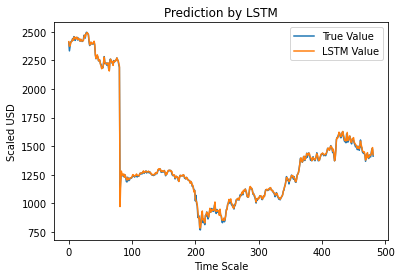

In [ ]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [ ]:
x_scaled_transf.head()

,P1,P2,P3,P4,P5,Date
0,-1.005883,-0.029695,-0.013250,0.003790,-0.002278,2000-01-04
1,-1.011319,-0.026822,-0.012324,0.004304,0.001840,2000-01-05
2,-1.013188,-0.025919,-0.012416,0.004146,-0.000436,2000-01-06
3,-1.014186,-0.025491,-0.013084,0.003757,0.000346,2000-01-07
4,-1.011581,-0.027269,-0.012691,0.003474,-0.000440,2000-01-10


In [ ]:
#!pip install autokeras

In [ ]:
print(x_scaled_transf.shape)
x_scaled_transf=x_scaled_transf.drop(['Date'],axis=1)


(5305, 6)


In [ ]:
x_scaled_transf.head()

,P1,P2,P3,P4,P5
0,-1.005883,-0.029695,-0.013250,0.003790,-0.002278
1,-1.011319,-0.026822,-0.012324,0.004304,0.001840
2,-1.013188,-0.025919,-0.012416,0.004146,-0.000436
3,-1.014186,-0.025491,-0.013084,0.003757,0.000346
4,-1.011581,-0.027269,-0.012691,0.003474,-0.000440


# Autokeras-StructuredDataRegressor with moving averages

In [ ]:
from autokeras import StructuredDataRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
# basic data preparation
X = x_scaled_transf.astype('float32')
y = output_var.astype('float32') 

In [ ]:
# separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4244, 5) (1061, 5) (4244, 1) (1061, 1)


In [ ]:
# Initialize the StructuredDataRegressor
reg = StructuredDataRegressor(max_trials=15,overwrite=True,metrics=['mae'])
# Search for the best model.
reg.fit(X_train.to_numpy(),y_train.to_numpy(), validation_split=0.2,epochs=100, verbose=0)

INFO:tensorflow:Oracle triggered exit
Epoch 1/100
133/133 [==============================] - 1s 3ms/step - loss: 1379086.1250 - mae: 990.5394
Epoch 2/100
133/133 [==============================] - 0s 3ms/step - loss: 838797.0000 - mae: 752.5018
Epoch 3/100
133/133 [==============================] - 0s 3ms/step - loss: 110074.2500 - mae: 238.2737
Epoch 4/100
133/133 [==============================] - 0s 3ms/step - loss: 26564.7617 - mae: 103.8654
Epoch 5/100
133/133 [==============================] - 0s 3ms/step - loss: 20323.2617 - mae: 89.0497
Epoch 6/100
133/133 [==============================] - 0s 3ms/step - loss: 15490.5537 - mae: 77.0272
Epoch 7/100
133/133 [==============================] - 0s 3ms/step - loss: 11641.2734 - mae: 66.0000
Epoch 8/100
133/133 [==============================] - 0s 3ms/step - loss: 8595.6914 - mae: 55.9278
Epoch 9/100
133/133 [==============================] - 0s 3ms/step - loss: 6321.0381 - mae: 47.2696
Epoch 10/100
133/133 [=========================

In [ ]:
predicted = reg.predict(X_test)

34/34 [==============================] - 0s 2ms/step


In [ ]:
# evaluate the model
loss, acc =reg.evaluate(X_train,y_train, verbose=0)
print('Accuracy: %.3f' % acc)
print('loss: %.3f' % loss)


Accuracy: 4.749
loss: 63.392


**EVALUATE MODEL PERFORMANCE FOR AutoKeras**

**MEAN ABSOLUTE ERROR (MAE) FOR TEST DATA**

In [ ]:
from sklearn.metrics import mean_absolute_error
print("MEAN ABSOLUTE ERROR (MAE) FOR TEST DATA IS")
np.round(mean_absolute_error(predicted,y_test),3)

MEAN ABSOLUTE ERROR (MAE) FOR TEST DATA IS


5.522

**MEAN SQUARE ERROR (MSE) FOR TEST DATA**

In [ ]:
from sklearn.metrics import mean_squared_error
print("MEAN SQUARE ERROR (MSE) FOR TEST DATA IS")
mse=np.round(mean_squared_error(predicted,y_test),3)
mse

MEAN SQUARE ERROR (MSE) FOR TEST DATA IS


477.984

**ROOT MEAN SQUARE ERROR (MSE) FOR TEST DATA**

In [ ]:
import math
math.sqrt(mse)

21.862845395534922

**MEDIAN ABSOLUTE ERROR (MAE) FOR TEST DATA**

In [ ]:
from sklearn.metrics import median_absolute_error
print("MEDIAN ABSOLUTE ERROR (MAE) FOR TEST DATA IS")
np.round(median_absolute_error(predicted,y_test),3)

MEDIAN ABSOLUTE ERROR (MAE) FOR TEST DATA IS


2.894

**Mean Absolute Percentage Error FOR TEST DATA**

In [ ]:
print("MAPE FOR TEST DATA IS")
mape1 = np.mean(np.abs((y_test - predicted)/y_test))*100
np.round(mape1,3)

MAPE FOR TEST DATA IS


Close    0.594
dtype: float32

**Get the best performing model and Summarize the loaded model**

In [ ]:
keras_model = reg.export_model()
keras_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 5)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense (Dense)               (None, 256)               1536      
                                                                 
 re_lu (ReLU)                (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                8224  

**View the visual representation of the model**

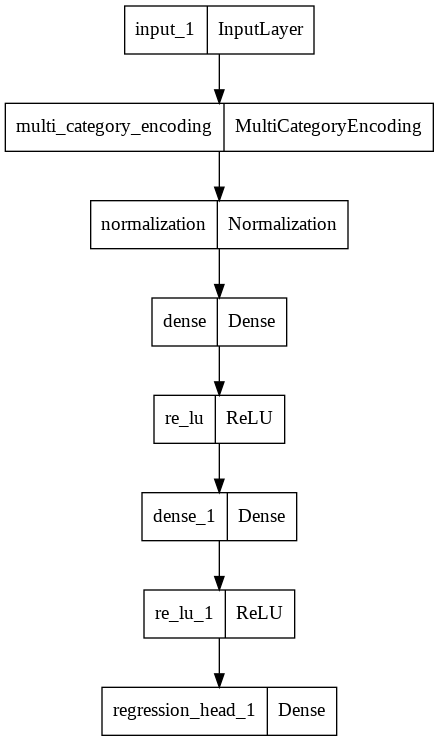

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model
plot_model(keras_model)

In [ ]:
!jupyter nbconvert StockMarketPrediction_PCA_LSTM_AutoKeras_MovingAverages.ipynb

[NbConvertApp] Converting notebook StockMarketPrediction_PCA_LSTM_AutoKeras_MovingAverages.ipynb to html
[NbConvertApp] Writing 563398 bytes to StockMarketPrediction_PCA_LSTM_AutoKeras_MovingAverages.html
